In [128]:
import os
import librosa
import sklearn
import scipy
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import noisereduce as nr
import seaborn as sns
from tqdm import tqdm
import warnings
from itertools import product

from scipy.io import wavfile
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


In [158]:
# Define paths
csv_file = 'common-voice/versions/2/cv-valid-train.csv'
mp3_folder = 'common-voice/versions/2/cv-valid-train'
output_csv = "assests/train_features_filter_2.csv"

SAMPLING_RATE = 16000          # sample_rate
AUDIO_LENGTH = 5               # seconds
EXPECT_DATASIZE = 10000

In [130]:
df = pd.read_csv(csv_file)
df.drop(['text', 'up_votes', 'down_votes', 'duration'], axis=1, inplace=True)
df.dropna(inplace=True)
print(df.shape)
print(df.head(1))

(63163, 4)
                           filename       age  gender accent
5  cv-valid-train/sample-000005.mp3  twenties  female     us


In [131]:
df = df[df['gender'] != 'other']
print(df.shape)

(62421, 4)


In [132]:
mapping = {'female' : 0, 'male' : 1, 
           'teens' : 0, 'twenties' : 1, 'thirties' : 2, 'forties' : 3, 'fifties' : 4, 'sixties' : 5, 'seventies' : 6, 'eighties' : 7}

accent_tags = {
    'accent': df['accent'].unique()
} 

for key in accent_tags:
    for id, option in enumerate(accent_tags[key]):
        mapping[option] = id
# print(mapping)

In [133]:
print(mapping)

{'female': 0, 'male': 1, 'teens': 0, 'twenties': 1, 'thirties': 2, 'forties': 3, 'fifties': 4, 'sixties': 5, 'seventies': 6, 'eighties': 7, 'us': 0, 'england': 1, 'australia': 2, 'indian': 3, 'canada': 4, 'malaysia': 5, 'ireland': 6, 'bermuda': 7, 'scotland': 8, 'african': 9, 'newzealand': 10, 'wales': 11, 'philippines': 12, 'singapore': 13, 'hongkong': 14, 'southatlandtic': 15}


In [134]:
df['age'] = df['age'].map(mapping)
df['gender'] = df['gender'].map(mapping)
df['accent'] = df['accent'].map(mapping)

In [146]:
def preprocessing(file):
    fixed_length = SAMPLING_RATE * AUDIO_LENGTH
    loaded_file, discard = librosa.load(file, sr=SAMPLING_RATE)
    assert discard == SAMPLING_RATE
    reduced_noise = nr.reduce_noise(y=loaded_file, sr=SAMPLING_RATE, stationary=False)
    y_trim, _ = librosa.effects.trim(reduced_noise, top_db=20)
    
    # cap audio length
    if len(y_trim) > fixed_length:
        y_trim = y_trim[:fixed_length]
    return y_trim

In [147]:
def onset(y):
    onsets = librosa.onset.onset_detect(y=y, sr=SAMPLING_RATE, units="time", hop_length=128, backtrack=True)
    number_of_words = len(onsets)
    duration = librosa.get_duration(y=y,sr=SAMPLING_RATE)
    onsets_per_sec = number_of_words/duration
    return  onsets_per_sec

In [148]:
def pitch(audio_data):
    f0, _, _= librosa.pyin(audio_data, sr=SAMPLING_RATE, fmin=60, fmax=600)

    S = np.abs(librosa.stft(audio_data))
    frequencies = librosa.fft_frequencies(sr=SAMPLING_RATE)
    harmonics = np.arange(1, 10)
    harmonics = librosa.f0_harmonics(S, f0=f0, harmonics=harmonics, freqs=frequencies)
    harmonic_energy = np.mean(harmonics,axis=1)
    harmonic_std = np.std(harmonics,axis=1,ddof=1)
    if (np.sum(harmonic_energy) != 0):
        harmonic_energy = harmonic_energy/np.sum(harmonic_energy)
        harmonic_std = harmonic_std/np.sum(harmonic_energy)
    
    pitch_features = {
    'f0_mean' : np.nanmean(f0),
    'f0_median' : np.nanmedian(f0),    
    'f0_var' : np.nanvar(f0,ddof=1), #ddof of 1 calculates sample variance, we use this due to sampling
    'f0_std' : np.nanstd(f0,ddof=1),
    'f0_5-percentile' : np.nanpercentile(f0, 5),
    'f0_95-percentile' : np.nanpercentile(f0, 95),
    'f0_energy' : harmonic_energy[0],
    'f1_energy' : harmonic_energy[1],
    'f2_energy' : harmonic_energy[2],
    'f3_energy' : harmonic_energy[3],
    'f4_energy' : harmonic_energy[4],
    'f5_energy' : harmonic_energy[5],
    'f6_energy' : harmonic_energy[6],
    'f7_energy' : harmonic_energy[7],
    'f8_energy' : harmonic_energy[8],
    'f0_energy_std' : harmonic_std[0],
    'f1_energy_std' : harmonic_std[1],
    'f2_energy_std' : harmonic_std[2],
    'f3_energy_std' : harmonic_std[3],
    'f4_energy_std' : harmonic_std[4],
    'f5_energy_std' : harmonic_std[5],
    'f6_energy_std' : harmonic_std[6],
    'f7_energy_std' : harmonic_std[7],
    'f8_energy_std' : harmonic_std[8],
    }

    return pitch_features

In [149]:
new_features = {
    'onsets_per_sec': [],
    'tempo': [],
    'f0_mean' : [],
    'f0_median' : [],
    'f0_var' : [],
    'f0_std' : [],
    'f0_5-percentile' : [],
    'f0_95-percentile' : [],
    'f0_energy' : [],
    'f1_energy' : [],
    'f2_energy' : [],
    'f3_energy' : [],
    'f4_energy' : [],
    'f5_energy' : [],
    'f6_energy' : [],
    'f7_energy' : [],
    'f8_energy' : [],
    'f0_energy_std' : [],
    'f1_energy_std' : [],
    'f2_energy_std' : [],
    'f3_energy_std' : [],
    'f4_energy_std' : [],
    'f5_energy_std' : [],
    'f6_energy_std' : [],
    'f7_energy_std' : [],
    'f8_energy_std' : [],
}

In [150]:
# Group by age, gender, accent combination
grouped = df.groupby(['age', 'gender', 'accent'])[['filename', 'age', 'gender', 'accent']]
group_sizes = grouped.size()
unique_combinations = group_sizes.reset_index(name='count')
print(unique_combinations)

     age  gender  accent  count
0    0.0       0       0    675
1    0.0       0       1    108
2    0.0       0       2     32
3    0.0       0       3      8
4    0.0       0       4     87
..   ...     ...     ...    ...
121  7.0       0       0     18
122  7.0       1       0     18
123  7.0       1       1    103
124  7.0       1       2     90
125  7.0       1       4     10

[126 rows x 4 columns]


In [151]:
n_rows_per_group = EXPECT_DATASIZE // len(grouped)
df_subset = grouped.apply(lambda group: group.sample(n=min(len(group), n_rows_per_group), random_state=0))
df_subset = df_subset.reset_index(drop=True)

In [152]:
df_subset.shape

(6441, 4)

In [153]:
n_rows = len(df_subset)
new_columns = pd.DataFrame(np.nan, index=range(n_rows), columns=new_features.keys())
# Step 4: Add the new columns to the DataFrame
df_subset = pd.concat([df_subset, new_columns], axis=1)

In [154]:
print(df_subset.head(1))

                           filename  age  gender  accent  onsets_per_sec  \
0  cv-valid-train/sample-162112.mp3  0.0       0       0             NaN   

   tempo  f0_mean  f0_median  f0_var  f0_std  ...  f8_energy  f0_energy_std  \
0    NaN      NaN        NaN     NaN     NaN  ...        NaN            NaN   

   f1_energy_std  f2_energy_std  f3_energy_std  f4_energy_std  f5_energy_std  \
0            NaN            NaN            NaN            NaN            NaN   

   f6_energy_std  f7_energy_std  f8_energy_std  
0            NaN            NaN            NaN  

[1 rows x 30 columns]


In [156]:
for index, row in tqdm(df_subset.iterrows(), total=len(df_subset), desc="Processing MP3 files", unit="file"):
    mp3_filename = row['filename']  
    mp3_file_path = os.path.join(mp3_folder, mp3_filename)

    if os.path.exists(mp3_file_path):
        # preprocessing
        y = preprocessing(mp3_file_path)
        # Onset
        onsets_per_sec = onset(y=y)
        df_subset.at[index, 'onsets_per_sec'] = onsets_per_sec

        # Tempo
        tempo = librosa.beat.beat_track(y=y, sr=SAMPLING_RATE, start_bpm=10)[0]
        df_subset.at[index, 'tempo'] = tempo
        
        # Pitch
        f0_values = pitch(y)
        for i, v in f0_values.items():
            df_subset.at[index, i] = v

print("Finished extracting MP3 files.")

Processing MP3 files: 100%|██████████| 6441/6441 [26:31<00:00,  4.05file/s]

Finished extracting MP3 files.


In [157]:
print(df_subset.shape)
df_subset.dropna(inplace=True)
print(df_subset.shape)

(6441, 30)
(6328, 30)


In [159]:
df_subset.to_csv(output_csv, index=False)

In [160]:
df_features = pd.read_csv(output_csv)
df_features.shape

(6328, 30)

In [161]:
df_features.dropna(inplace=True)
df_features.shape

(6328, 30)

In [162]:
df_features.head(10)

,filename,age,gender,accent,onsets_per_sec,tempo,f0_mean,f0_median,f0_var,f0_std,...,f8_energy,f0_energy_std,f1_energy_std,f2_energy_std,f3_energy_std,f4_energy_std,f5_energy_std,f6_energy_std,f7_energy_std,f8_energy_std
0,cv-valid-train/sample-162112.mp3,0.0,0,0,5.600000,28.846154,244.490622,240.000000,420.876802,20.515282,...,0.005774,4.175737,9.368398,3.609466,2.940303,1.635783,1.407479,0.535793,0.354292,0.218985
1,cv-valid-train/sample-008810.mp3,0.0,0,0,5.000000,125.000000,165.076200,152.066364,856.826424,29.271598,...,0.023387,13.621801,18.578964,7.898444,22.892269,24.192163,1.700655,2.932733,2.529104,2.392170
2,cv-valid-train/sample-099830.mp3,0.0,0,0,6.365741,48.076923,263.265740,260.976860,994.923965,31.542415,...,0.012160,7.468726,8.377332,6.806384,1.387558,0.675204,1.238710,0.643432,0.823805,0.738911
3,cv-valid-train/sample-051442.mp3,0.0,0,0,5.208333,18.750000,274.710395,260.214449,3662.581281,60.519264,...,0.013299,8.391182,8.538996,8.992476,5.863021,1.824484,3.527810,2.471710,2.252307,0.782793
4,cv-valid-train/sample-113781.mp3,0.0,0,0,5.408654,24.671053,250.920592,242.788666,897.908325,29.965118,...,0.007391,5.346293,15.860094,4.892166,1.985858,0.724157,0.884155,0.270121,0.159308,0.341145
5,cv-valid-train/sample-088363.mp3,0.0,0,0,5.408654,32.327586,322.005777,313.044497,5414.498469,73.583276,...,0.011226,7.301153,14.200761,6.494940,13.567901,3.540057,4.756337,1.348052,0.817423,0.747809
6,cv-valid-train/sample-094135.mp3,0.0,0,0,6.770833,45.731707,278.577310,278.890941,918.532868,30.307307,...,0.010006,14.376652,7.672112,5.126090,2.461065,2.029176,1.063523,0.706814,0.900020,0.539631
7,cv-valid-train/sample-004551.mp3,0.0,0,0,6.981383,48.076923,210.709492,200.656117,1334.368172,36.529005,...,0.020457,1.221713,1.648289,1.837067,1.174164,0.575851,0.788919,0.401818,0.139253,0.236383
8,cv-valid-train/sample-070758.mp3,0.0,0,0,5.813953,38.265306,199.899807,199.497095,966.441441,31.087641,...,0.046621,1.121961,4.731159,2.460912,3.222348,1.959223,0.719666,1.241953,0.799012,0.804092
9,cv-valid-train/sample-048391.mp3,0.0,0,0,5.208333,62.500000,230.467815,231.824719,1517.757511,38.958407,...,0.013241,0.608882,0.830695,2.233121,0.884590,0.655495,0.532641,0.396856,0.365634,0.108567


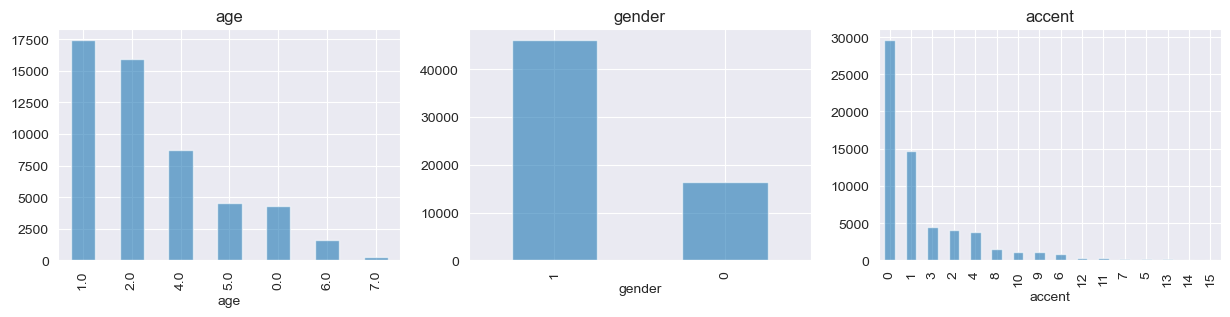

In [211]:
fig, axes = plt.subplots(1, 3, figsize=(15, 3))
for i, c in enumerate(["age", "gender", "accent"]):
    df[c].value_counts().plot.bar(title=c, ax=axes[i], alpha=0.6)
plt.savefig("assests/tar_dist_ori.png");

# Predict

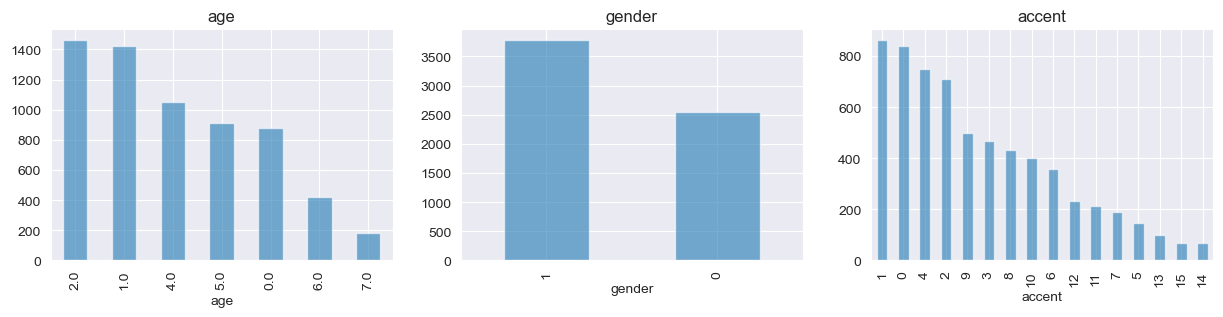

In [212]:
fig, axes = plt.subplots(1, 3, figsize=(15, 3))
for i, c in enumerate(["age", "gender", "accent"]):
    df_features[c].value_counts().plot.bar(title=c, ax=axes[i], alpha=0.6)
plt.savefig("assests/tar_dist.png");

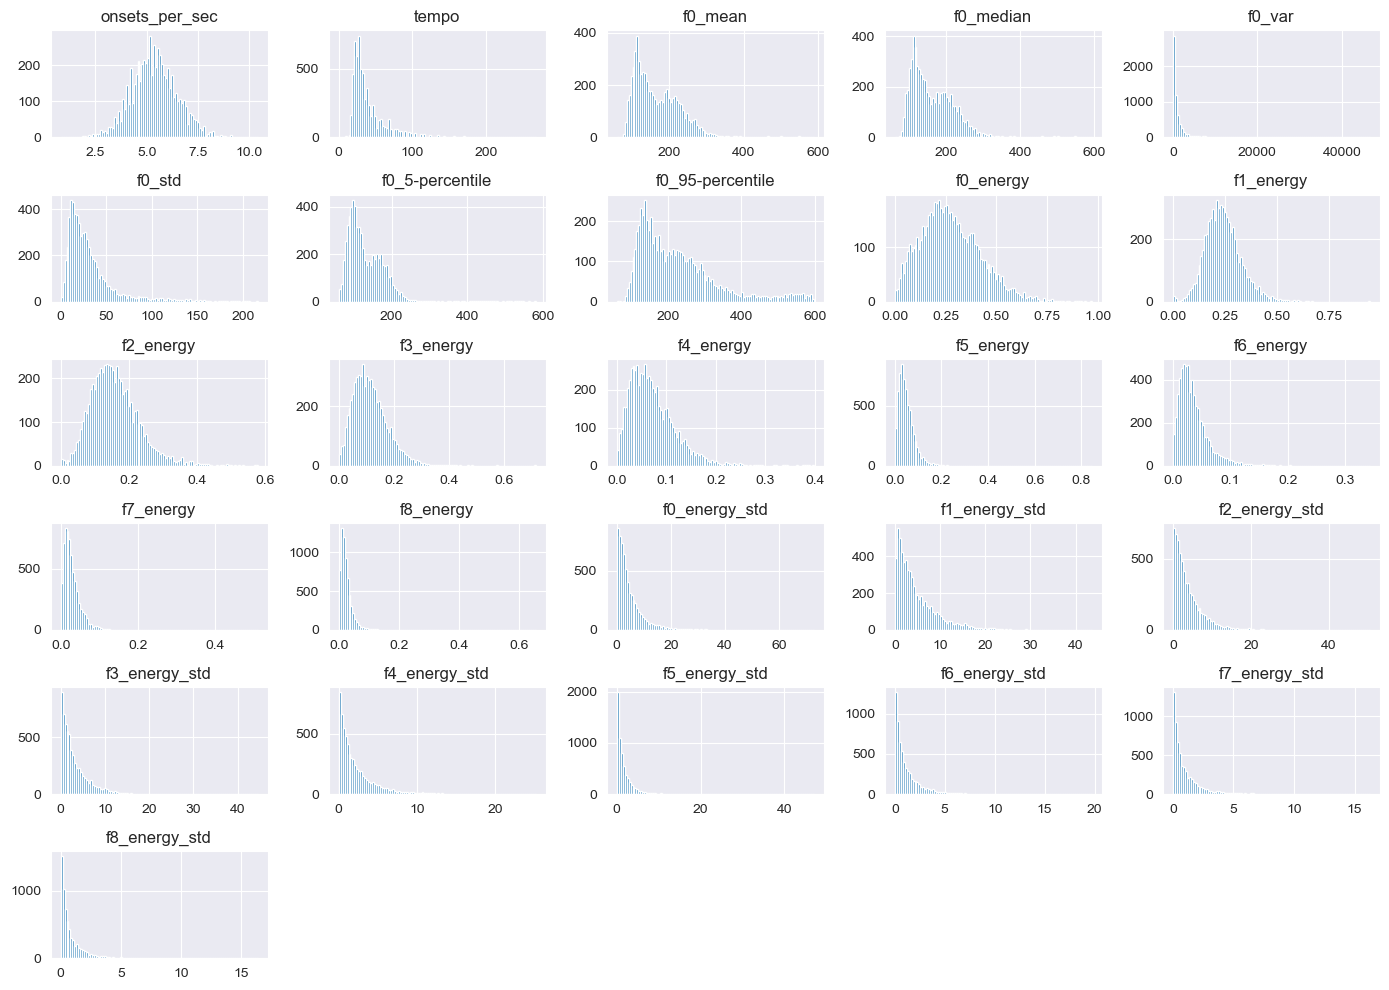

In [213]:
df_features.drop(columns=["age", "gender", "filename", "accent"]).hist(bins=100, figsize=(14, 10))
plt.tight_layout()
plt.savefig('assests/dist.png')

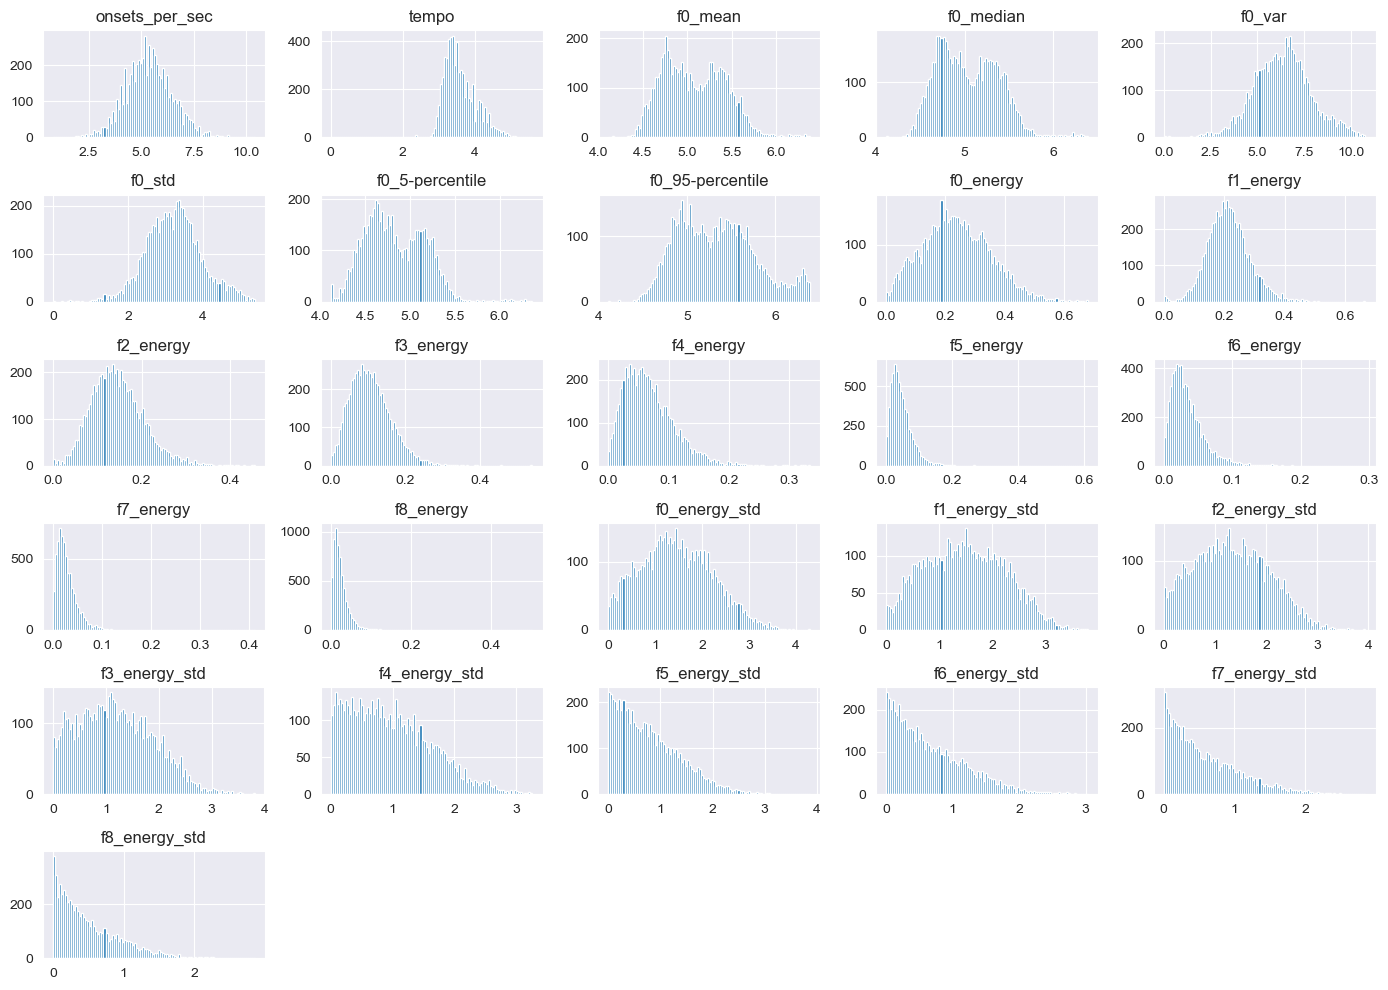

In [214]:
df_features_transform = df_features.apply(
    lambda x: np.log1p(x)
    if x.name not in ["age", "gender", "filename", "accent", "onsets_per_sec"]
    else x)

# Let's look at the distribution once more
df_features_transform.drop(columns=["age", "gender", "filename", "accent"], errors='ignore').hist(bins=100, figsize=(14, 10))
plt.tight_layout()
plt.show();

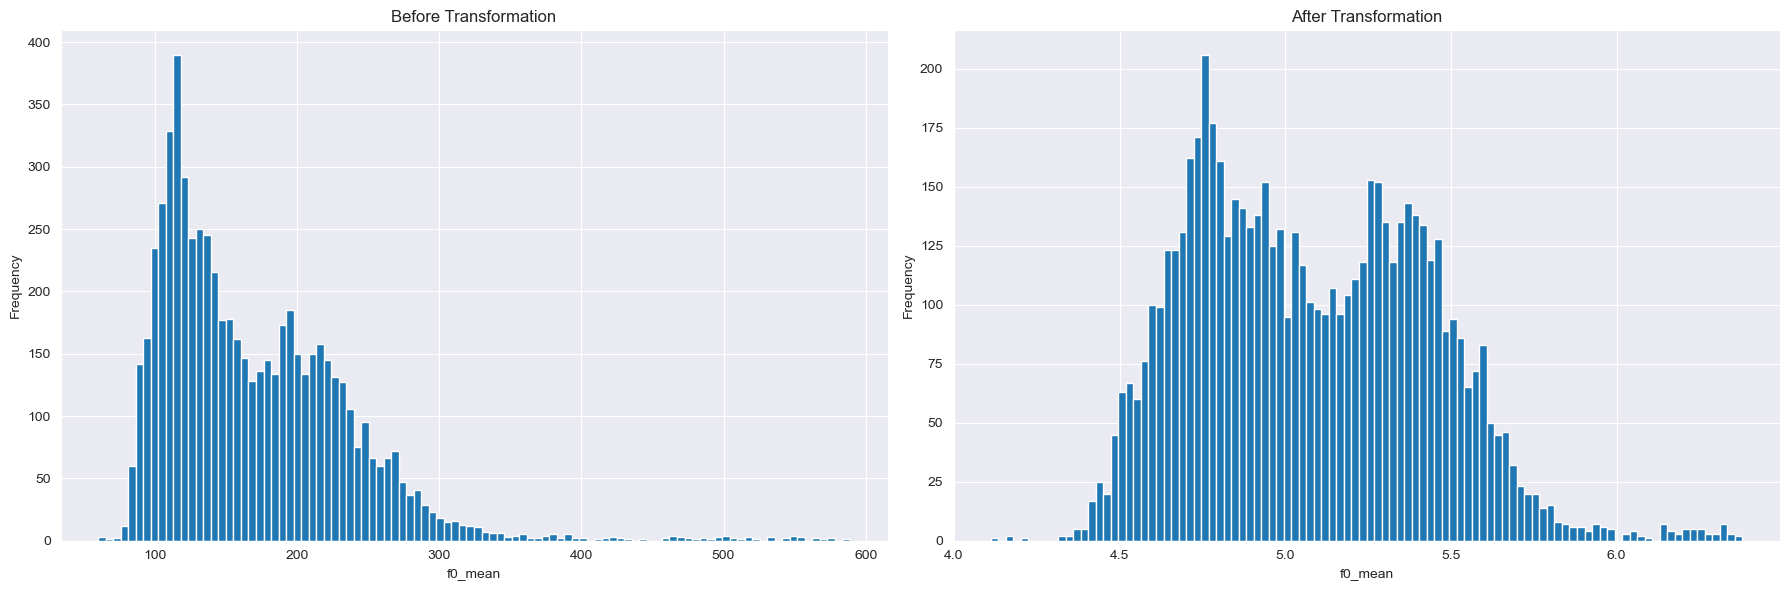

In [215]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # Adjust figsize for side-by-side view

# First histogram for 'f0_mean' before transformation
df_features['f0_mean'].hist(bins=100, ax=axes[0])
axes[0].set_title('Before Transformation')
axes[0].set_xlabel('f0_mean')
axes[0].set_ylabel('Frequency')

# Second histogram for 'f0_mean' after transformation
df_features_transform['f0_mean'].hist(bins=100, ax=axes[1])
axes[1].set_title('After Transformation')
axes[1].set_xlabel('f0_mean')
axes[1].set_ylabel('Frequency')

# Adjust layout for better spacing
plt.tight_layout()
plt.savefig("assests/bf_logtransform.png")

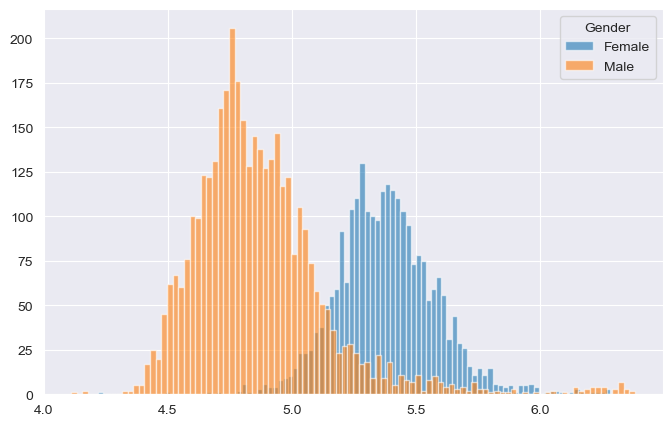

In [219]:
for g in df_features_transform.gender.unique():
    # Plot the histogram for each gender group
    df_features_transform[df_features_transform["gender"].eq(g)]["f0_mean"].hist(
        bins=100, figsize=(8, 5), label="Female" if g == 0 else "Male", alpha=0.6)

# Set the legend with custom labels for Female and Male
plt.legend(title="Gender")
plt.savefig("assests/f0_gender.png")

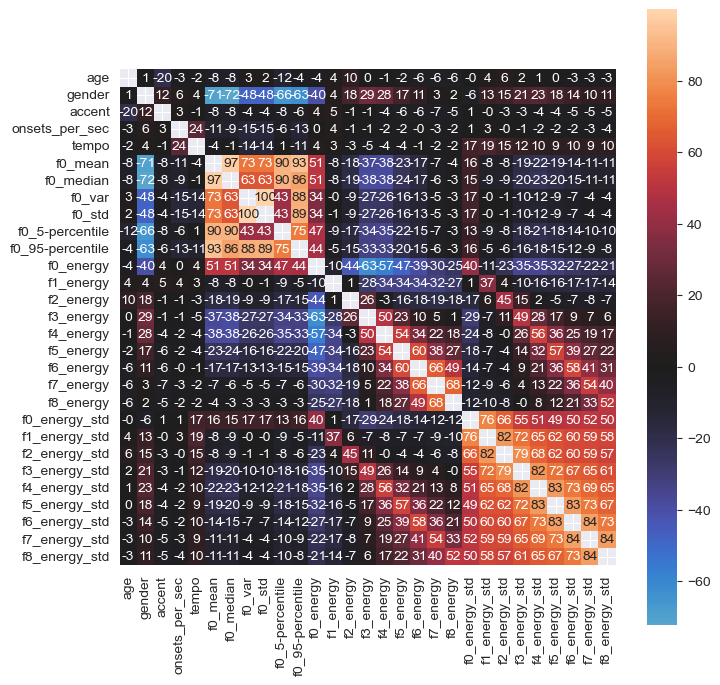

In [216]:
plt.figure(figsize=(8, 8))
# df_corr = df_features_transform.iloc[:, 1:13].drop(columns=["filename", "number_of_words", "duration","word_per_sec"], errors='ignore').corr() * 100
df_corr = df_features_transform.drop(columns=["filename"], errors='ignore').corr() * 100
sns.heatmap(df_corr, square=True, annot=True, fmt=".0f", 
            mask=np.eye(len(df_corr)), center=0)
plt.savefig("assests/feature coor.png")

In [181]:
targets = ["age","gender","accent"]
def draw_pca_capture(dataframe):
    x = dataframe.drop(columns=["filename", "age","gender","accent"]).reset_index(drop=True)
    pca = PCA()
    pca.fit(x)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    line_90 = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.90) + 1
    line_99 =np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.99) + 1
    plt.axvline(x=line_90, color='r', linestyle='--', label='x = 5')
    plt.axvline(x=line_99, color='r', linestyle='--', label='x = 5')
    print(line_90, line_99)
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    

5 12


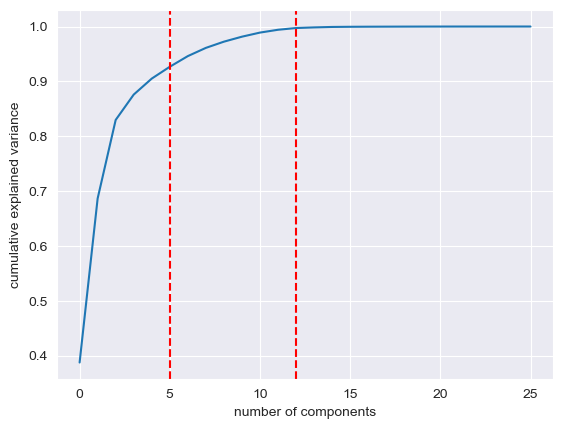

In [183]:
draw_pca_capture(df_features_transform)
plt.savefig("assests/PCA_analysis.png")

In [184]:
def draw_2d_PCA(dataframe, target, ax):
    x = dataframe.drop(columns=["filename", "age", "gender", "accent"]).reset_index(drop=True)
    y = dataframe[target].values
    pca = PCA(n_components=2)
    X_PCA = pca.fit_transform(x)
    df_pca = pd.DataFrame(X_PCA, columns=["PCA1", "PCA2"])
    df_pca[target] = y

    # Plot the PCA-transformed data
    scatter = ax.scatter(df_pca["PCA1"], df_pca["PCA2"], c=df_pca[target], cmap="viridis", alpha=0.7)
    ax.set_title(f"PCA Visualization (2 Components): {target}", fontsize=14)
    ax.set_xlabel("Principal Component 1", fontsize=12)
    ax.set_ylabel("Principal Component 2", fontsize=12)
    plt.colorbar(scatter, ax=ax, label=target)

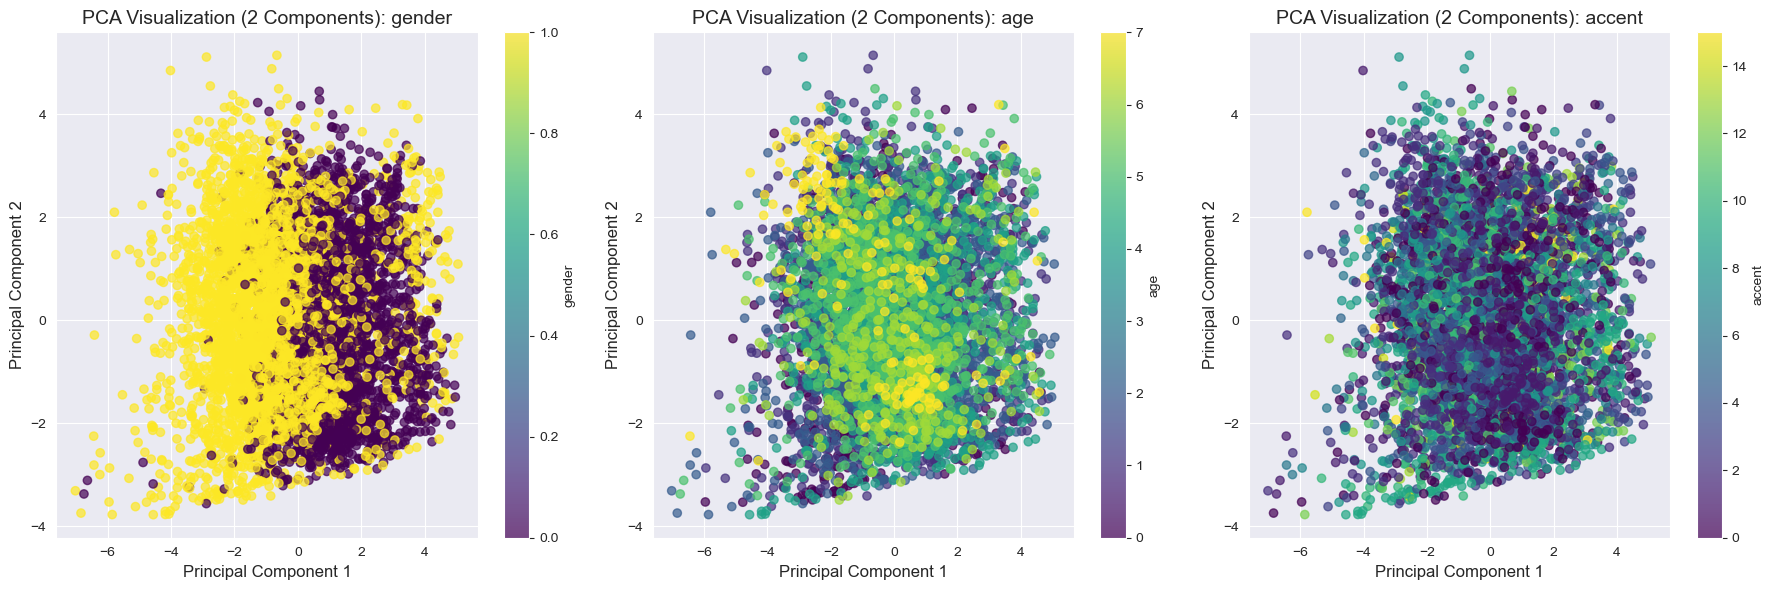

In [185]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

targets = ['gender', 'age', 'accent']  
for i, target in enumerate(targets):
    draw_2d_PCA(df_features_transform, target, axes[i])

plt.tight_layout()
plt.savefig("assests/PCA_2cmp.png")

In [200]:
def split_by_feature(df, feature, test_size=0.2):
    # Stratify based on the selected feature
    train_df, test_df = train_test_split(
        df, 
        test_size=test_size, 
        stratify=df[feature],  # Stratify on the selected feature
        random_state=42
    )
    return train_df, test_df
# train_df, test_df = split_by_feature(df_first_13, "age")
# test_df['accent'].value_counts()

In [240]:
def predict(dataframe, target, n_components = 0):
    warnings.filterwarnings("ignore")
    train_df, test_df = split_by_feature(dataframe,target)
    y_train = train_df[target]
    y_test = test_df[target]
    X_train = train_df.drop(columns=["filename", "age","gender","accent"], errors="ignore")
    X_test = test_df.drop(columns=["filename", "age","gender","accent"], errors="ignore")
    # print(train_df.head(1))
    if n_components>0:
        pca = PCA(n_components=n_components)
        X_train = pca.fit_transform(X_train)
        X_test = pca.fit_transform(X_test)
    
    # print(X_train.shape)
    
    model = LogisticRegression(max_iter=1000, random_state=0, solver='lbfgs')
    model.fit(X_train, y_train)
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    # Evaluate the model
    if n_components>0:
        print(f"Classification Report on target: {target} and PCA with n_components ={n_components}:")
    else:
        print(f"Classification Report on target: {target} and with origin feature")
    print(classification_report(y_test, y_pred))
    print("Accuracy Score:", accuracy_score(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)

    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_pred), yticklabels=np.unique(y_pred))
    plt.title(f"Confusion Matrix for {target} with n_components={n_components}")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    

gender 0
Classification Report on target: gender and with origin feature
              precision    recall  f1-score   support

           0       0.89      0.87      0.88       510
           1       0.91      0.93      0.92       756

    accuracy                           0.90      1266
   macro avg       0.90      0.90      0.90      1266
weighted avg       0.90      0.90      0.90      1266

Accuracy Score: 0.9036334913112164


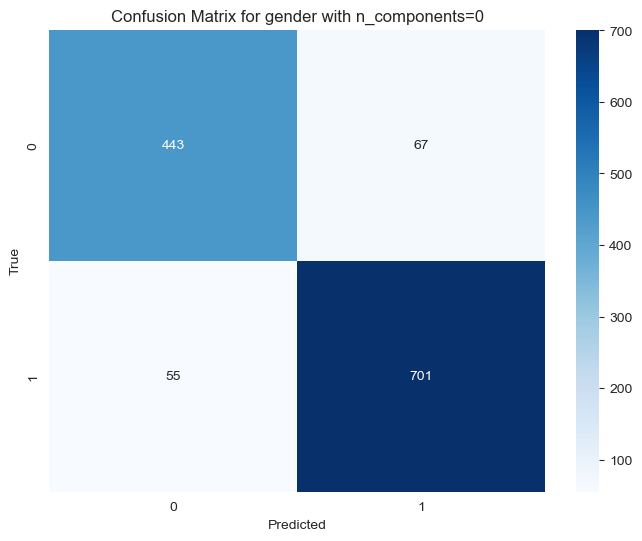

gender 2
Classification Report on target: gender and PCA with n_components =2:
              precision    recall  f1-score   support

           0       0.73      0.67      0.70       510
           1       0.79      0.84      0.81       756

    accuracy                           0.77      1266
   macro avg       0.76      0.75      0.76      1266
weighted avg       0.77      0.77      0.77      1266

Accuracy Score: 0.768562401263823


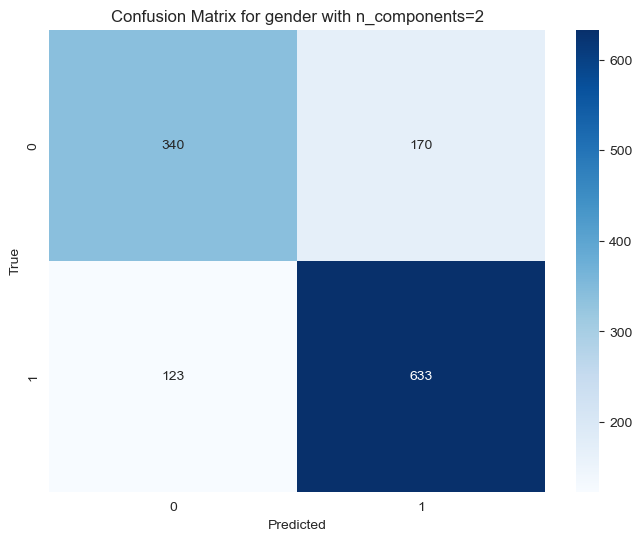

gender 5
Classification Report on target: gender and PCA with n_components =5:
              precision    recall  f1-score   support

           0       0.79      0.79      0.79       510
           1       0.86      0.86      0.86       756

    accuracy                           0.83      1266
   macro avg       0.83      0.83      0.83      1266
weighted avg       0.83      0.83      0.83      1266

Accuracy Score: 0.8317535545023697


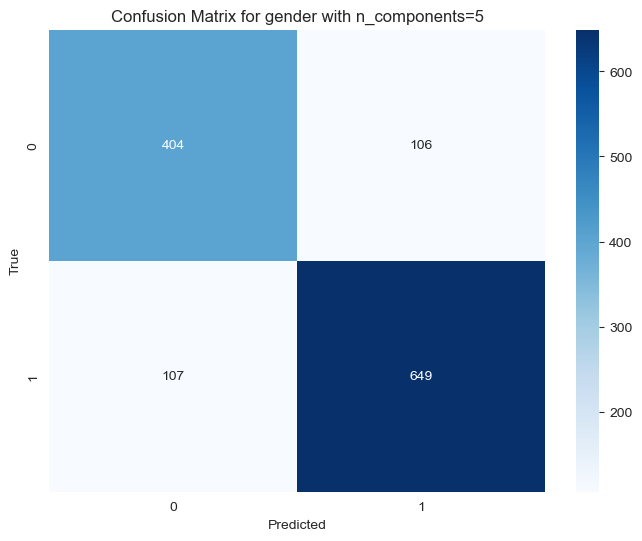

gender 12
Classification Report on target: gender and PCA with n_components =12:
              precision    recall  f1-score   support

           0       0.85      0.84      0.85       510
           1       0.89      0.90      0.90       756

    accuracy                           0.88      1266
   macro avg       0.87      0.87      0.87      1266
weighted avg       0.88      0.88      0.88      1266

Accuracy Score: 0.8759873617693523


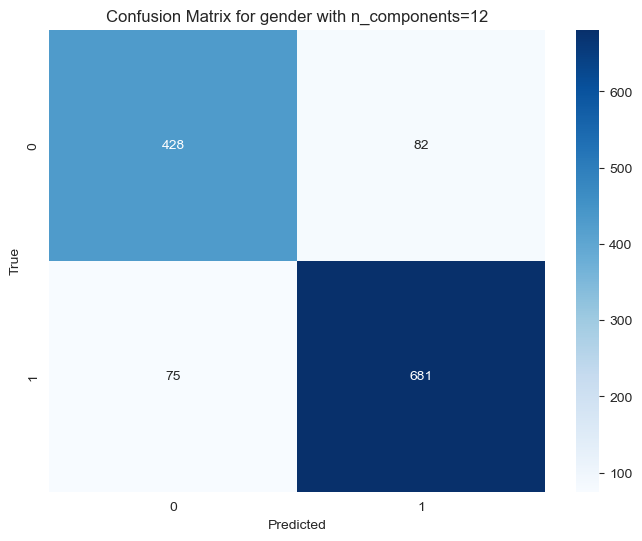

age 0
Classification Report on target: age and with origin feature
              precision    recall  f1-score   support

         0.0       0.10      0.02      0.03       176
         1.0       0.26      0.50      0.34       285
         2.0       0.30      0.51      0.38       292
         4.0       0.19      0.07      0.10       210
         5.0       0.32      0.18      0.23       183
         6.0       0.62      0.06      0.11        84
         7.0       0.71      0.14      0.23        36

    accuracy                           0.28      1266
   macro avg       0.36      0.21      0.20      1266
weighted avg       0.28      0.28      0.23      1266

Accuracy Score: 0.27804107424960506


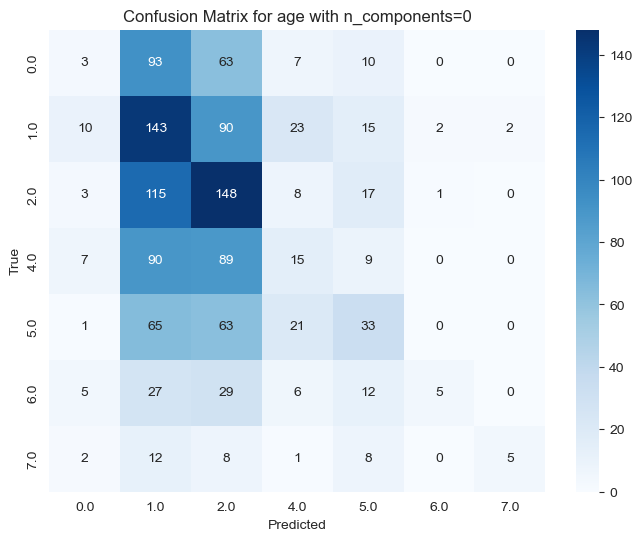

age 2
Classification Report on target: age and PCA with n_components =2:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       176
         1.0       0.23      0.41      0.29       285
         2.0       0.25      0.63      0.35       292
         4.0       0.00      0.00      0.00       210
         5.0       0.00      0.00      0.00       183
         6.0       0.00      0.00      0.00        84
         7.0       0.00      0.00      0.00        36

    accuracy                           0.24      1266
   macro avg       0.07      0.15      0.09      1266
weighted avg       0.11      0.24      0.15      1266

Accuracy Score: 0.2377567140600316


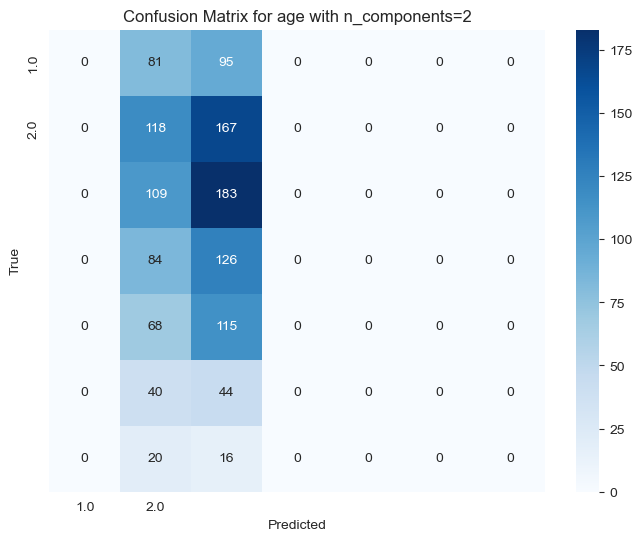

age 5
Classification Report on target: age and PCA with n_components =5:
              precision    recall  f1-score   support

         0.0       0.29      0.01      0.02       176
         1.0       0.26      0.44      0.32       285
         2.0       0.24      0.52      0.33       292
         4.0       0.09      0.01      0.02       210
         5.0       0.23      0.11      0.15       183
         6.0       0.00      0.00      0.00        84
         7.0       0.43      0.08      0.14        36

    accuracy                           0.24      1266
   macro avg       0.22      0.17      0.14      1266
weighted avg       0.21      0.24      0.18      1266

Accuracy Score: 0.2424960505529226


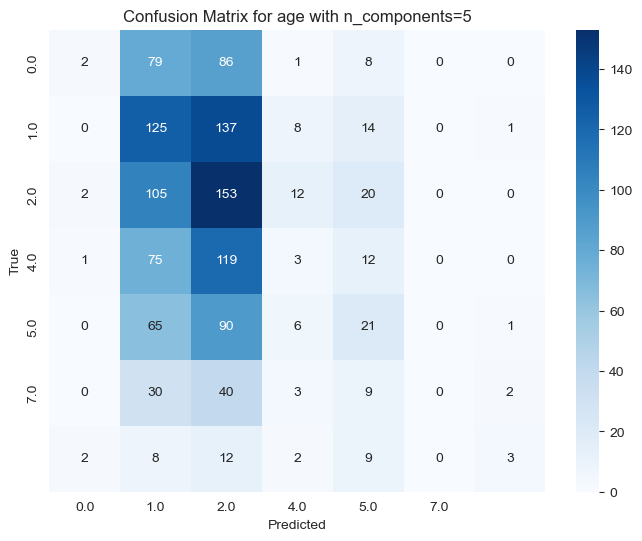

age 12
Classification Report on target: age and PCA with n_components =12:
              precision    recall  f1-score   support

         0.0       0.19      0.03      0.05       176
         1.0       0.28      0.46      0.34       285
         2.0       0.26      0.51      0.34       292
         4.0       0.10      0.03      0.04       210
         5.0       0.22      0.14      0.17       183
         6.0       0.45      0.06      0.11        84
         7.0       0.75      0.17      0.27        36

    accuracy                           0.26      1266
   macro avg       0.32      0.20      0.19      1266
weighted avg       0.25      0.26      0.21      1266

Accuracy Score: 0.2575039494470774


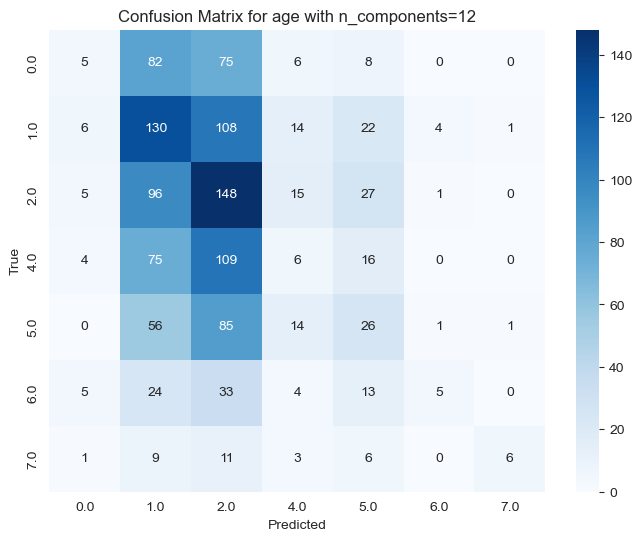

accent 0
Classification Report on target: accent and with origin feature
              precision    recall  f1-score   support

           0       0.17      0.24      0.20       168
           1       0.19      0.39      0.26       172
           2       0.20      0.30      0.24       142
           3       0.26      0.30      0.28        93
           4       0.20      0.17      0.19       150
           5       0.47      0.31      0.38        29
           6       0.25      0.01      0.03        72
           7       0.00      0.00      0.00        38
           8       0.15      0.15      0.15        86
           9       0.25      0.15      0.19        99
          10       0.23      0.11      0.15        80
          11       0.00      0.00      0.00        43
          12       0.00      0.00      0.00        46
          13       0.00      0.00      0.00        20
          14       0.00      0.00      0.00        14
          15       0.00      0.00      0.00        14

    acc

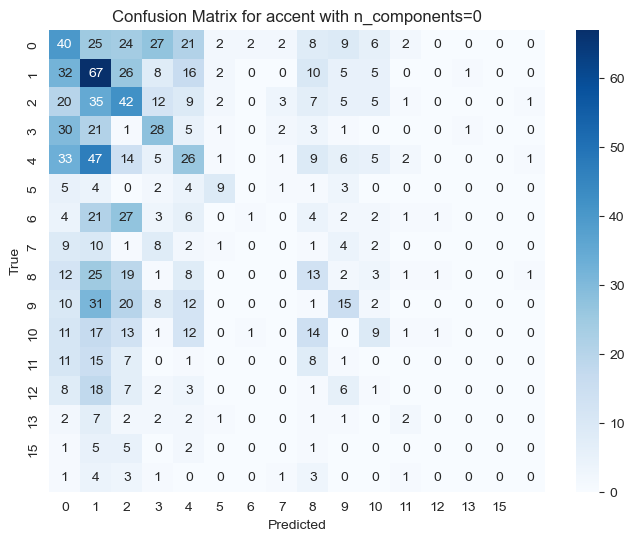

accent 2
Classification Report on target: accent and PCA with n_components =2:
              precision    recall  f1-score   support

           0       0.16      0.40      0.23       168
           1       0.16      0.51      0.24       172
           2       0.09      0.13      0.11       142
           3       0.18      0.14      0.16        93
           4       0.00      0.00      0.00       150
           5       0.00      0.00      0.00        29
           6       0.00      0.00      0.00        72
           7       0.00      0.00      0.00        38
           8       0.09      0.02      0.04        86
           9       0.00      0.00      0.00        99
          10       0.00      0.00      0.00        80
          11       0.00      0.00      0.00        43
          12       0.00      0.00      0.00        46
          13       0.00      0.00      0.00        20
          14       0.00      0.00      0.00        14
          15       0.00      0.00      0.00        14

 

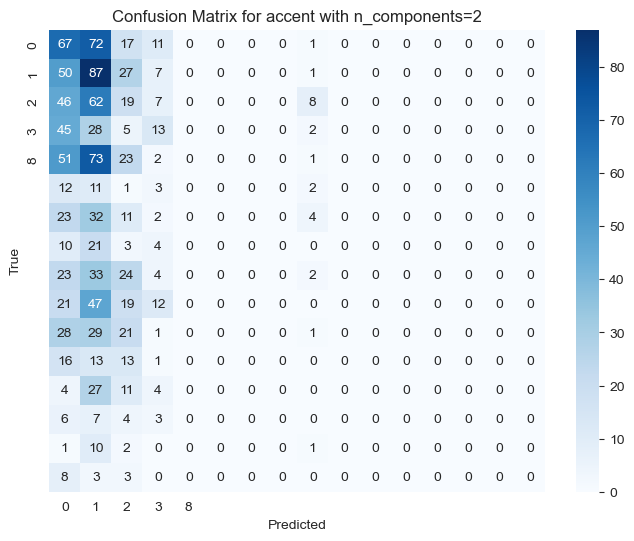

accent 5
Classification Report on target: accent and PCA with n_components =5:
              precision    recall  f1-score   support

           0       0.16      0.23      0.19       168
           1       0.16      0.46      0.24       172
           2       0.16      0.31      0.21       142
           3       0.23      0.28      0.25        93
           4       0.15      0.01      0.02       150
           5       0.29      0.14      0.19        29
           6       0.00      0.00      0.00        72
           7       0.00      0.00      0.00        38
           8       0.21      0.10      0.14        86
           9       0.20      0.10      0.13        99
          10       0.07      0.03      0.04        80
          11       0.00      0.00      0.00        43
          12       0.00      0.00      0.00        46
          13       0.00      0.00      0.00        20
          14       0.00      0.00      0.00        14
          15       0.00      0.00      0.00        14

 

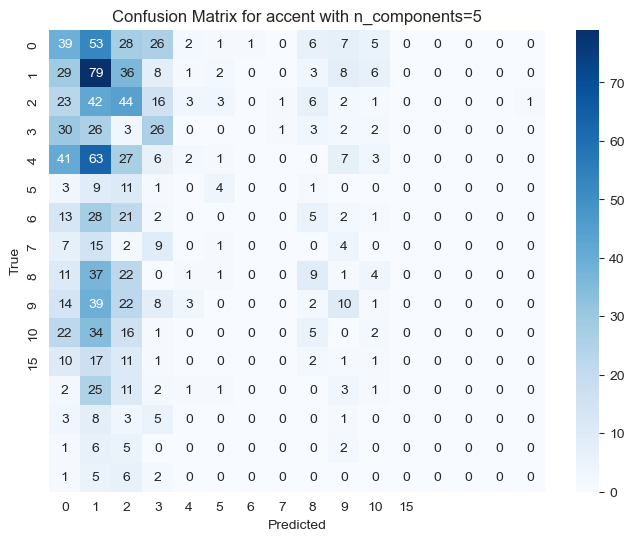

accent 12
Classification Report on target: accent and PCA with n_components =12:
              precision    recall  f1-score   support

           0       0.13      0.19      0.16       168
           1       0.16      0.35      0.22       172
           2       0.17      0.20      0.18       142
           3       0.22      0.24      0.23        93
           4       0.14      0.13      0.13       150
           5       0.00      0.00      0.00        29
           6       0.25      0.01      0.03        72
           7       0.11      0.03      0.04        38
           8       0.12      0.09      0.10        86
           9       0.11      0.08      0.09        99
          10       0.08      0.04      0.05        80
          11       0.00      0.00      0.00        43
          12       0.00      0.00      0.00        46
          13       0.00      0.00      0.00        20
          14       0.00      0.00      0.00        14
          15       0.00      0.00      0.00        14


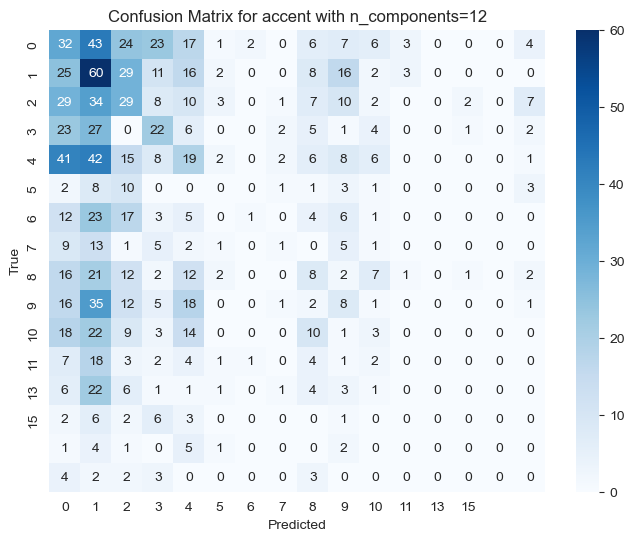

In [241]:
for target in targets:
    for i in [0,2,5,12]:
        print(target, i)
        predict(df_features_transform , target, n_components = i)


Target: gender, Training Rows: 5062, Testing Rows: 1266
[0 1]
[0 1]
[0 1]
[0 1]
Target: age, Training Rows: 5062, Testing Rows: 1266
[0. 1. 2. 4. 5. 6. 7.]
[1. 2.]
[0. 1. 2. 4. 5. 7.]
[0. 1. 2. 4. 5. 6. 7.]
Target: accent, Training Rows: 5062, Testing Rows: 1266
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15]
[0 1 2 3 8]
[ 0  1  2  3  4  5  7  8  9 10 15]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15]


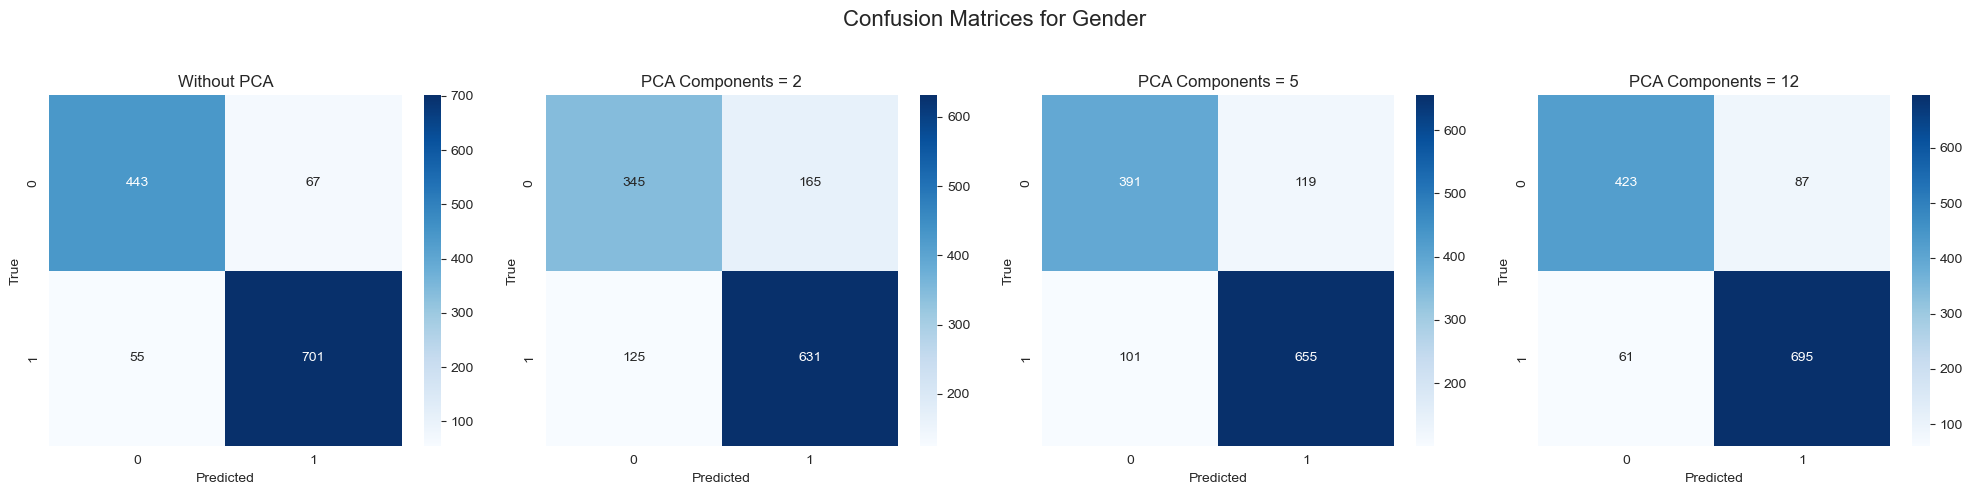

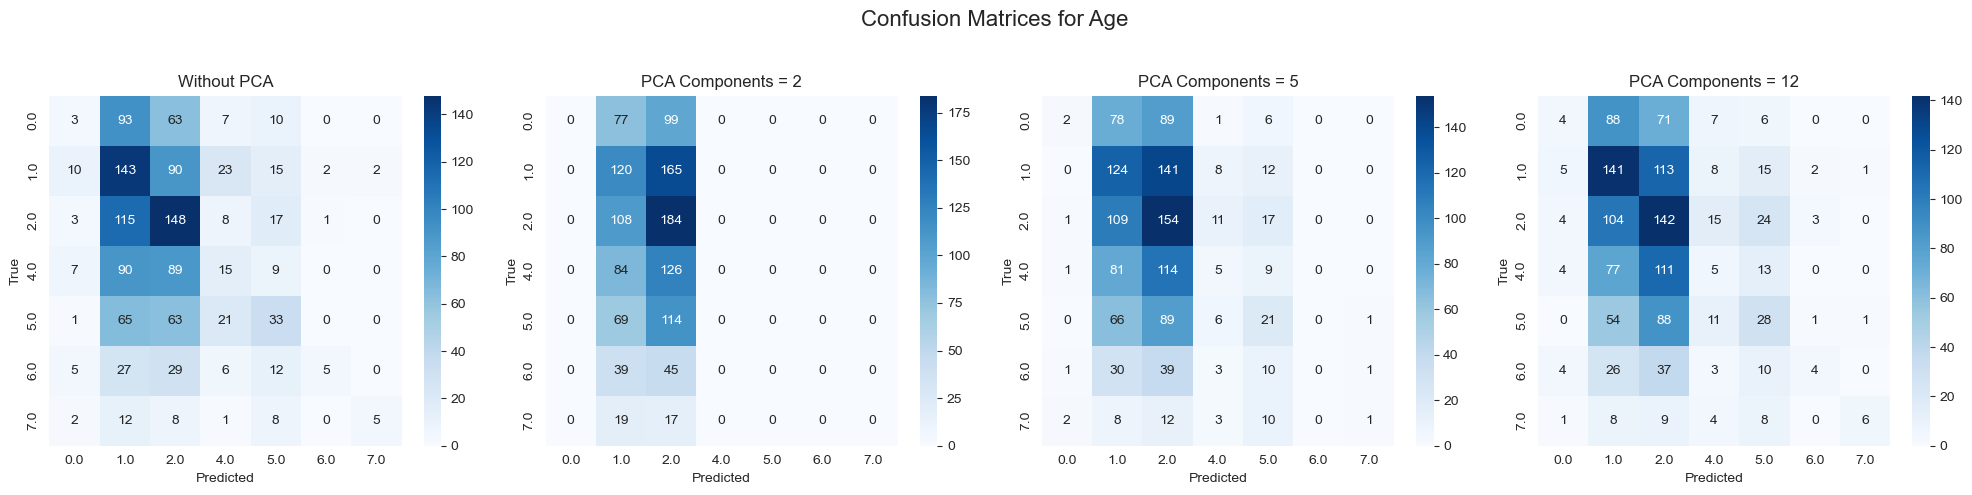

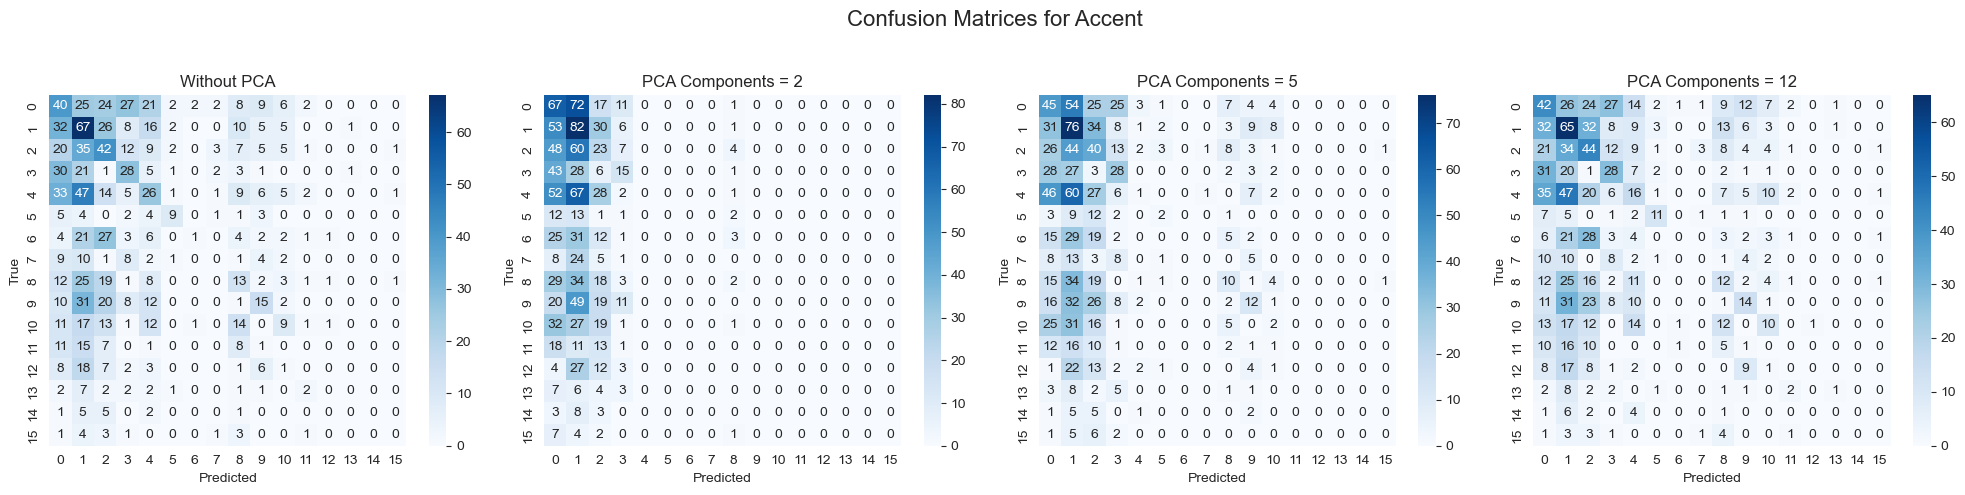

In [259]:
def predict_and_plot(dataframe, target, n_components_list):
    warnings.filterwarnings("ignore")
    # Split data into train and test sets
    train_df, test_df = split_by_feature(dataframe, target)
    print(f"Target: {target}, Training Rows: {len(train_df)}, Testing Rows: {len(test_df)}")
    y_train = train_df[target]
    y_test = test_df[target]
    # Set up subplots for all confusion matrices in one row
    fig, axes = plt.subplots(1, len(n_components_list), figsize=(20, 5))
    
    for idx, n_components in enumerate(n_components_list):
        
        X_train = train_df.drop(columns=["filename", "age", "gender", "accent"], errors="ignore")
        X_test = test_df.drop(columns=["filename", "age", "gender", "accent"], errors="ignore")
        # Apply PCA if required
        if n_components>0:
            pca = PCA(n_components=n_components)
            X_train = pca.fit_transform(X_train)
            X_test = pca.transform(X_test)

        # Train logistic regression model
        model = LogisticRegression(max_iter=1000, random_state=0, solver='lbfgs')
        model.fit(X_train, y_train)
        
        # Predict and evaluate
        y_pred = model.predict(X_test)
        print(np.unique(y_pred))
        cm = confusion_matrix(y_test, y_pred)
        
        # Plot confusion matrix
        ax = axes[idx]
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                    xticklabels=np.unique(y_test), 
                    yticklabels=np.unique(y_test), 
                    ax=ax)
        if n_components ==0:
           ax.set_title(f"Without PCA") 
        else:
            ax.set_title(f"PCA Components = {n_components}")
        
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')

    # Set overall title
    fig.suptitle(f"Confusion Matrices for {target.capitalize()}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f"assests/Confusion Matrices for {target.capitalize()}")

# Define targets and PCA components to evaluate
targets = ['gender', 'age', 'accent']
n_components_list = [0, 2, 5, 12]

# Loop through targets and generate plots
for target in targets:
    predict_and_plot(df_features_transform, target, n_components_list)


Target: gender, Training Rows: 5062, Testing Rows: 1266
Target: age, Training Rows: 5062, Testing Rows: 1266
Target: accent, Training Rows: 5062, Testing Rows: 1266


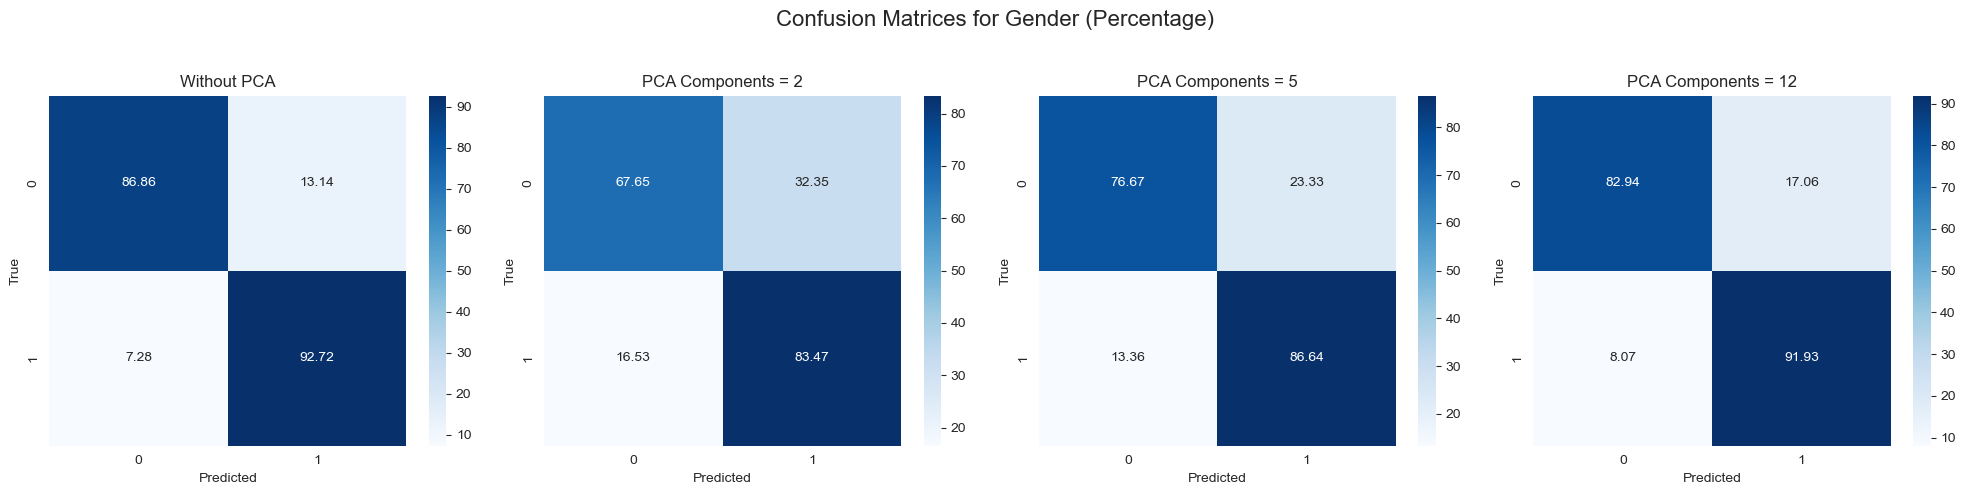

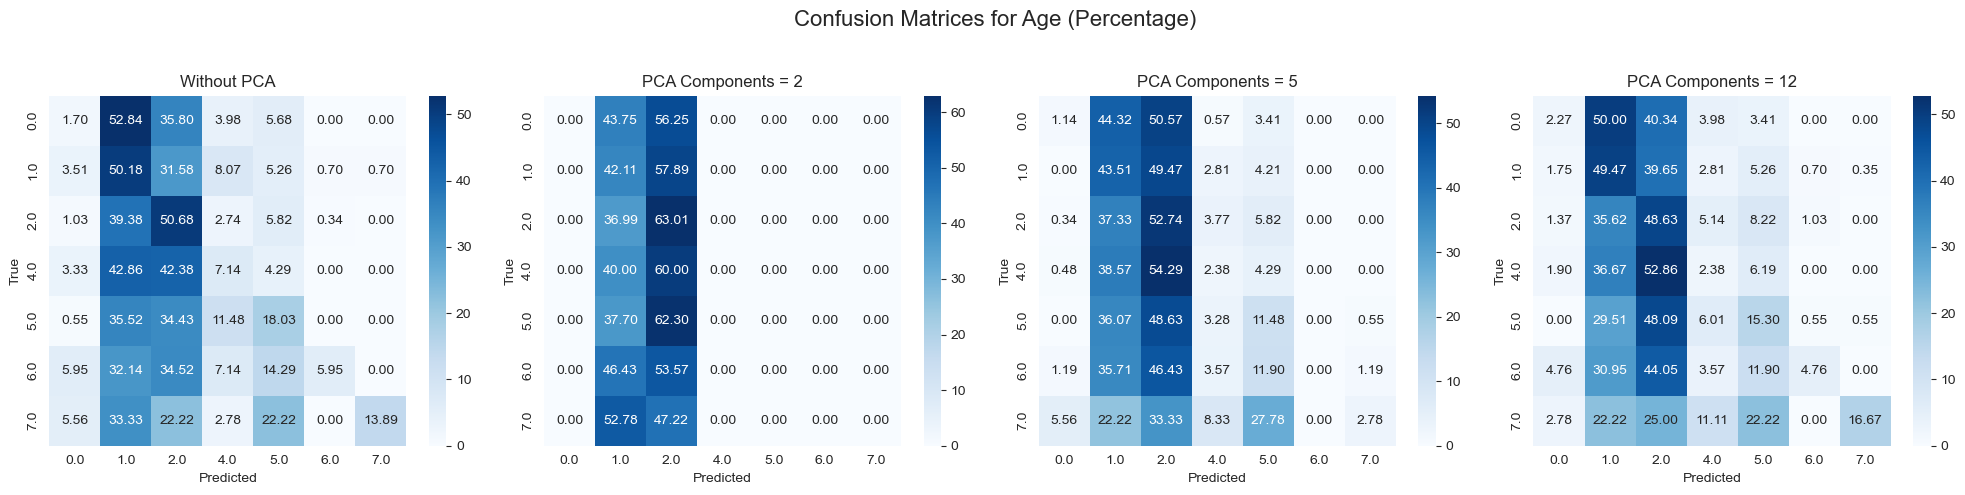

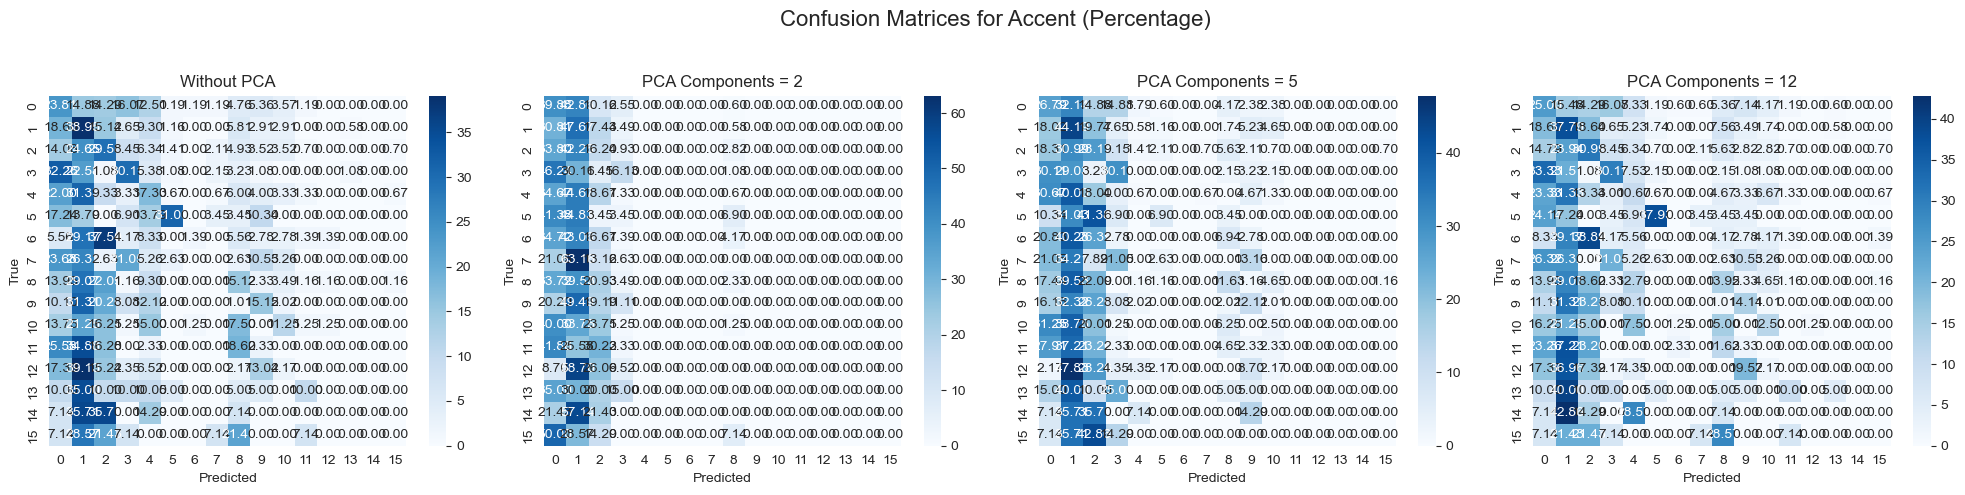

In [260]:
def predict_and_plot_percentage(dataframe, target, n_components_list):
    warnings.filterwarnings("ignore")
    # Split data into train and test sets
    train_df, test_df = split_by_feature(dataframe, target)
    print(f"Target: {target}, Training Rows: {len(train_df)}, Testing Rows: {len(test_df)}")
    y_train = train_df[target]
    y_test = test_df[target]
    # Set up subplots for all confusion matrices in one row
    fig, axes = plt.subplots(1, len(n_components_list), figsize=(20, 5))
    
    for idx, n_components in enumerate(n_components_list):
        
        X_train = train_df.drop(columns=["filename", "age", "gender", "accent"], errors="ignore")
        X_test = test_df.drop(columns=["filename", "age", "gender", "accent"], errors="ignore")
        # Apply PCA if required
        if n_components > 0:
            pca = PCA(n_components=n_components)
            X_train = pca.fit_transform(X_train)
            X_test = pca.transform(X_test)

        # Train logistic regression model
        model = LogisticRegression(max_iter=1000, random_state=0, solver='lbfgs')
        model.fit(X_train, y_train)
        
        # Predict and evaluate
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Convert to percentages
        
        # Plot confusion matrix
        ax = axes[idx]
        sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", 
                    xticklabels=np.unique(y_test), 
                    yticklabels=np.unique(y_test), 
                    ax=ax)
        if n_components == 0:
            ax.set_title(f"Without PCA")
        else:
            ax.set_title(f"PCA Components = {n_components}")
        
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')

    # Set overall title
    fig.suptitle(f"Confusion Matrices for {target.capitalize()} (Percentage)", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f"assests/Confusion_Matrices_Percentage_{target.capitalize()}.png")

# Define targets and PCA components to evaluate
targets = ['gender', 'age', 'accent']
n_components_list = [0, 2, 5, 12]

# Loop through targets and generate plots
for target in targets:
    predict_and_plot_percentage(df_features_transform, target, n_components_list)

# Single Test: preprocessing

In [ ]:
mp3_filename = "cv-valid-train/sample-000019.mp3" 
mp3_file_path = os.path.join(mp3_folder, mp3_filename)
y, _ = librosa.load(mp3_file_path)
y_trim, _ = preprocessing(mp3_file_path)

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(y)
plt.title('Original Audio Waveform')

plt.subplot(2, 1, 2)
plt.plot(y_trim)
plt.title('Processed Audio (Noise Reduced and Trimmed) Waveform')

plt.tight_layout()
plt.show()

# Single Test: Onset

In [ ]:
onsets = librosa.onset.onset_detect(y=y_trim, sr=sample_rate, units="time", hop_length=128, backtrack=True)
plt.figure(figsize=(12, 6))
for o in onsets:
    plt.vlines(o, min(y_trim), max(y_trim), colors="r")
librosa.display.waveshow(y_trim,sr=sample_rate)
plt.tight_layout()
plt.show()
# Return number of onsets
number_of_words = len(onsets)
print(f"{number_of_words} onsets were detected in this audio signal.")

duration = librosa.get_duration(y=y_trim,sr=sample_rate)
print(duration)

# Single Test: Fundamental frequency

In [ ]:
f0_values = pitch(y=y_trim)
f0_values

# Single Test: FFT

In [ ]:
r = fft(y_trim)
sampled_frequencies = r.keys()
sampled_magnitudes = r.values()
# Plot the restricted spectrum
plt.figure(figsize=(10, 4))
plt.plot(sampled_frequencies, sampled_magnitudes, label="Restricted Spectrum")
plt.title("Frequency Spectrum (Restricted to 500 Points)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
mp3_filename = "cv-valid-train/sample-000020.mp3" 
mp3_file_path = os.path.join(mp3_folder, mp3_filename)
y, sr = librosa.load(mp3_file_path)

reduced_noise = nr.reduce_noise(y=y, sr=sr, stationary=False)
y_trim, _ = librosa.effects.trim(reduced_noise, top_db=20)
f0 = pitch(y_trim)
print(f0)
print(y_trim.shape)
if len(y_trim) < 5 * 16000:
    print("pad")
    y_trim = np.pad(y_trim, (0, 5 * 16000 - len(y_trim)), mode='constant')
else:
    y_trim = y_trim[:5 * 16000]
print(y_trim.shape)
f0 = pitch(y_trim)
print(f0)


In [ ]:
f = fft_new(y)

In [ ]:
f